In [1]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os
import tqdm
import pandas as pd
import keras
import time, warnings
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import KFold, train_test_split, LeaveOneGroupOut, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    Activation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")


In [4]:

#class for plotting
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def normalize(clip):
    normalized_clip = (clip - np.min(clip)) / (np.max(clip) - np.min(clip))
    return normalized_clip

def conv_array(root_folder):
    metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_3/processed_data.csv')
    folds = {}
    for fold in range(1, 11):
        fold_path = os.path.join(root_folder, f"fold{fold}")
        image_data = []
        all_labels = []
        if not os.path.exists(fold_path):
            continue  # Skip if the folder doesn't exist
        for filename in tqdm.tqdm(os.listdir(fold_path)):
            if filename.endswith(".png"):
                image_path = os.path.join(fold_path, filename)
                image = Image.open(image_path)
                new_filename = filename.replace('.png', '.wav')
                row_num = metadata[metadata['slice_file_name'] == new_filename].index
                if not row_num.empty:
                    image_array = np.array(image)
                    if not image_array.shape == (76, 33):
                      continue
                    image_array = normalize(image_array)
                    #image_array = tensorflow.image.grayscale_to_rgb(image_array)
                    #print(image_array.shape)
                    image_array = np.ndarray(shape=(image_array.shape[0], image_array.shape[1], 1), dtype= np.uint8)
                    label = metadata.iloc[row_num]['labelID'].values[0]
                    #print(f'Double check: image {new_filename} has label {label}')
                    all_labels.append(label)
                    image_data.append(image_array)
                else:
                    print(f'{new_filename} not found')
                    continue
        image_data = np.array(image_data)
        #print(image_data)
        all_labels = np.array(all_labels)
        all_labels = to_categorical(all_labels - 1, num_classes=10)
        #converting numpy arrays to tf.tensor for GPU optimization
        image_data_tensor = tensorflow.convert_to_tensor(image_data)
        all_labels_tensor = tensorflow.convert_to_tensor(all_labels)
        #print(image_data_tensor)
        image_data_tensor = tensorflow.image.grayscale_to_rgb(image_data_tensor)
        folds[f"fold{fold}"] = [image_data_tensor, all_labels_tensor]
    return folds


root_folder = r"/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_3/both"
data = conv_array(root_folder)
input_shape = data['fold1'][0].shape
#input_shape = input_shape + (3,)
print(input_shape)

100%|██████████| 837/837 [00:09<00:00, 87.68it/s] 

(873, 76, 33, 3)


In [5]:

print(input_shape)
input_shape2 = input_shape[1:4]
print(input_shape2)

(873, 76, 33, 3)
(76, 33, 3)


29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 76, 33, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 82, 39, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 38, 17, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

  0%|          | 0/10 [00:00<?, ?it/s]

Training using fold1 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.69678, saving model to model.h5
61/61 - 33s - loss: 1.7962 - accuracy: 0.4280 - val_loss: 2.6968 - val_accuracy: 0.3562 - lr: 0.0010 - 33s/epoch - 536ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.69678 to 2.06324, saving model to model.h5
61/61 - 8s - loss: 1.4082 - accuracy: 0.5186 - val_loss: 2.0632 - val_accuracy: 0.3551 - lr: 0.0010 - 8s/epoch - 131ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.06324 to 1.71664, saving model to model.h5
61/61 - 11s - loss: 1.3270 - accuracy: 0.5404 - val_loss: 1.7166 - val_accuracy: 0.4662 - lr: 0.0010 - 11s/epoch - 176ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.71664 to 1.54116, saving model to model.h5
61/61 - 9s - loss: 1.2453 - accuracy: 0.5651 - val_loss: 1.5412 - val_accuracy: 0.4570 - lr: 0.0010 - 9s/epoch - 147ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.54116 to 1.41768, saving model to model.h5
61/61 - 9s - loss: 1.178

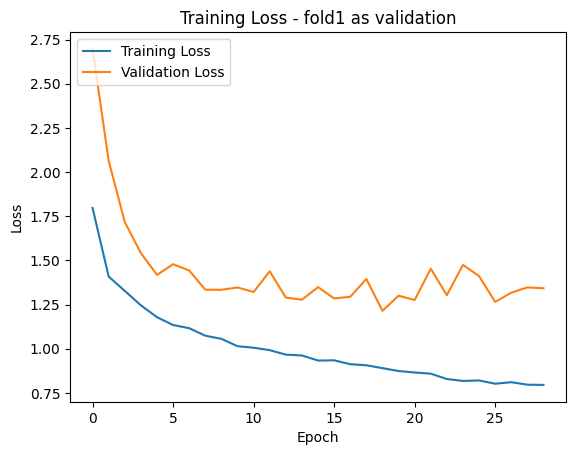

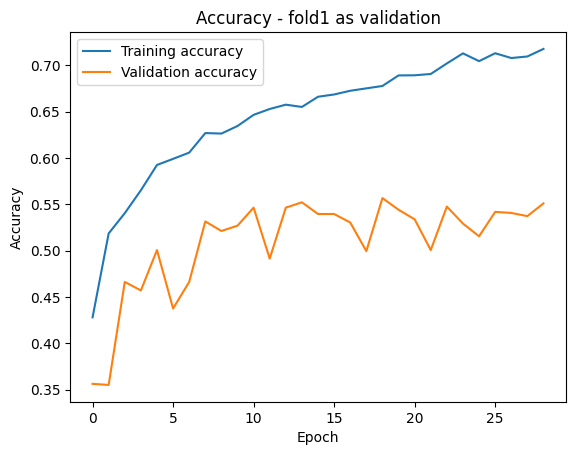

 10%|█         | 1/10 [05:02<45:26, 302.92s/it]

Training using fold2 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.88879, saving model to model.h5
61/61 - 22s - loss: 0.8336 - accuracy: 0.7030 - val_loss: 0.8888 - val_accuracy: 0.6757 - lr: 0.0010 - 22s/epoch - 356ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.88879
61/61 - 9s - loss: 0.8033 - accuracy: 0.7135 - val_loss: 0.9735 - val_accuracy: 0.6486 - lr: 0.0010 - 9s/epoch - 151ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.88879
61/61 - 7s - loss: 0.7771 - accuracy: 0.7217 - val_loss: 0.9524 - val_accuracy: 0.6824 - lr: 0.0010 - 7s/epoch - 117ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.88879
61/61 - 10s - loss: 0.7604 - accuracy: 0.7304 - val_loss: 0.9361 - val_accuracy: 0.6757 - lr: 0.0010 - 10s/epoch - 157ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.88879
61/61 - 7s - loss: 0.7605 - accuracy: 0.7263 - val_loss: 1.0340 - val_accuracy: 0.6655 - lr: 0.0010 - 7s/epoch - 114ms/step
Epoch 6/30

Epoch 6:

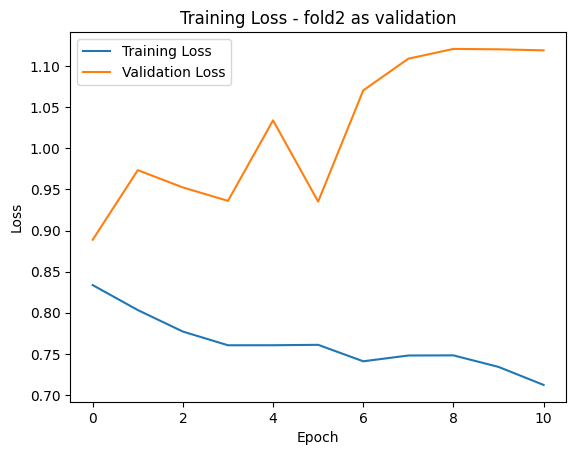

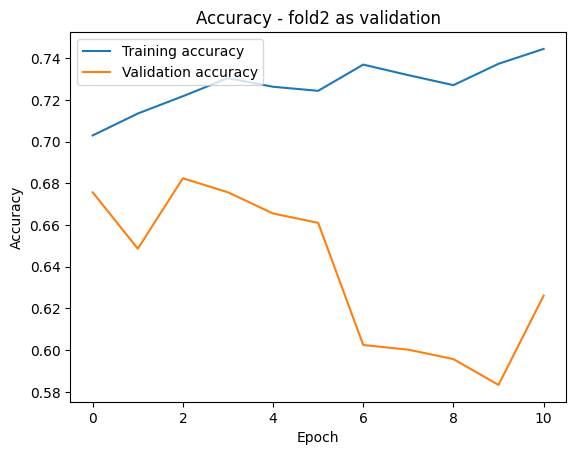

 20%|██        | 2/10 [07:03<26:06, 195.75s/it]

Training using fold3 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.88638, saving model to model.h5
60/60 - 22s - loss: 0.7424 - accuracy: 0.7341 - val_loss: 0.8864 - val_accuracy: 0.6908 - lr: 0.0010 - 22s/epoch - 358ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.88638
60/60 - 9s - loss: 0.7191 - accuracy: 0.7407 - val_loss: 0.9641 - val_accuracy: 0.6724 - lr: 0.0010 - 9s/epoch - 152ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.88638
60/60 - 7s - loss: 0.7271 - accuracy: 0.7398 - val_loss: 0.8972 - val_accuracy: 0.6822 - lr: 0.0010 - 7s/epoch - 120ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.88638
60/60 - 10s - loss: 0.7020 - accuracy: 0.7446 - val_loss: 0.9985 - val_accuracy: 0.6486 - lr: 0.0010 - 10s/epoch - 161ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.88638
60/60 - 7s - loss: 0.6765 - accuracy: 0.7554 - val_loss: 1.0142 - val_accuracy: 0.6400 - lr: 0.0010 - 7s/epoch - 116ms/step
Epoch 6/30

Epoch 6:

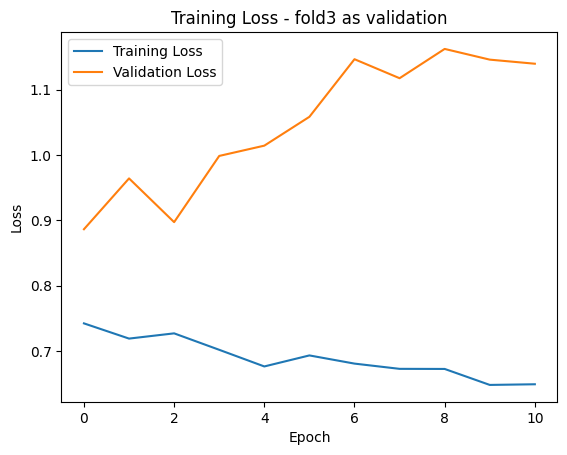

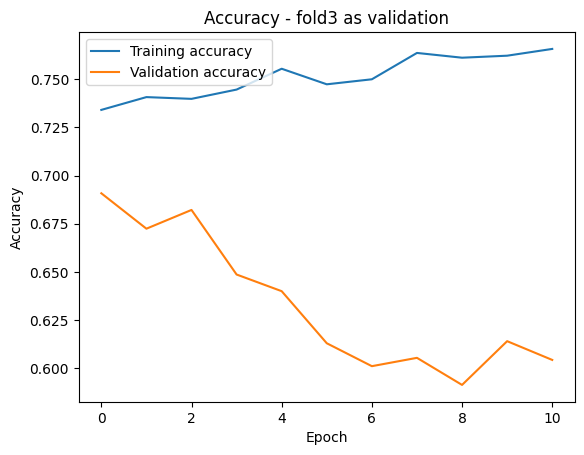

 30%|███       | 3/10 [09:04<18:49, 161.41s/it]

Training using fold4 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.92003, saving model to model.h5
60/60 - 22s - loss: 0.6782 - accuracy: 0.7604 - val_loss: 0.9200 - val_accuracy: 0.6646 - lr: 0.0010 - 22s/epoch - 370ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.92003
60/60 - 9s - loss: 0.6601 - accuracy: 0.7570 - val_loss: 1.0791 - val_accuracy: 0.6263 - lr: 0.0010 - 9s/epoch - 152ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.92003
60/60 - 8s - loss: 0.6466 - accuracy: 0.7695 - val_loss: 1.0838 - val_accuracy: 0.6253 - lr: 0.0010 - 8s/epoch - 132ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.92003
60/60 - 9s - loss: 0.6345 - accuracy: 0.7706 - val_loss: 1.0925 - val_accuracy: 0.6394 - lr: 0.0010 - 9s/epoch - 154ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.92003
60/60 - 7s - loss: 0.6372 - accuracy: 0.7700 - val_loss: 1.1435 - val_accuracy: 0.6172 - lr: 0.0010 - 7s/epoch - 119ms/step
Epoch 6/30

Epoch 6: v

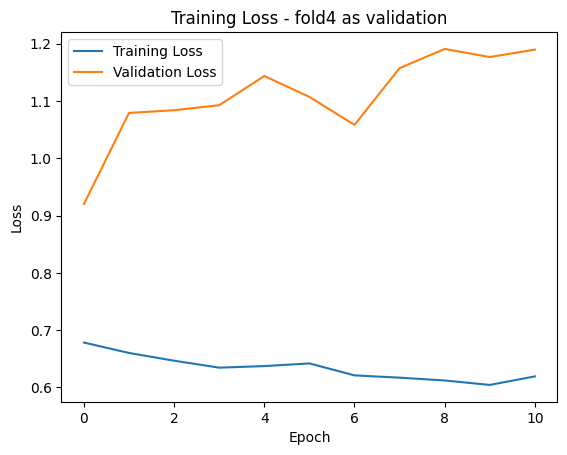

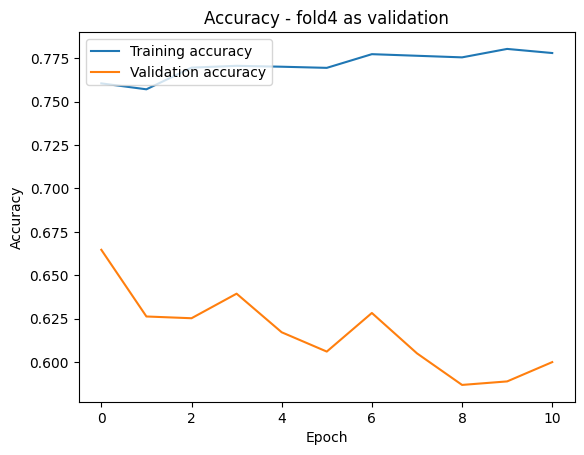

 40%|████      | 4/10 [11:04<14:31, 145.27s/it]

Training using fold5 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.79465, saving model to model.h5
60/60 - 21s - loss: 0.6362 - accuracy: 0.7709 - val_loss: 0.7946 - val_accuracy: 0.7041 - lr: 0.0010 - 21s/epoch - 345ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.79465
60/60 - 9s - loss: 0.6179 - accuracy: 0.7786 - val_loss: 0.8106 - val_accuracy: 0.6944 - lr: 0.0010 - 9s/epoch - 144ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.79465
60/60 - 7s - loss: 0.6174 - accuracy: 0.7778 - val_loss: 0.8337 - val_accuracy: 0.6838 - lr: 0.0010 - 7s/epoch - 124ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.79465
60/60 - 10s - loss: 0.6037 - accuracy: 0.7873 - val_loss: 0.8910 - val_accuracy: 0.6592 - lr: 0.0010 - 10s/epoch - 163ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.79465
60/60 - 7s - loss: 0.6015 - accuracy: 0.7825 - val_loss: 0.8533 - val_accuracy: 0.6699 - lr: 0.0010 - 7s/epoch - 119ms/step
Epoch 6/30

Epoch 6:

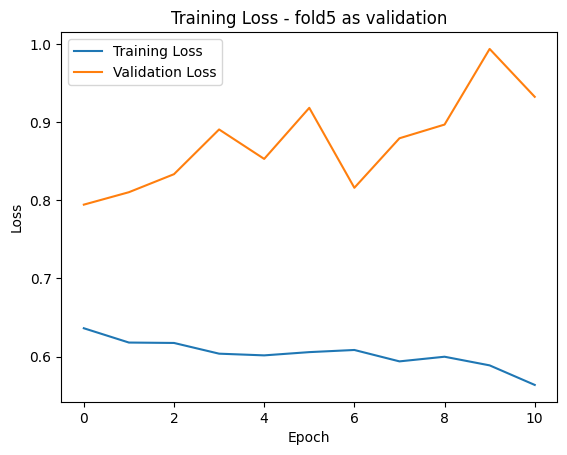

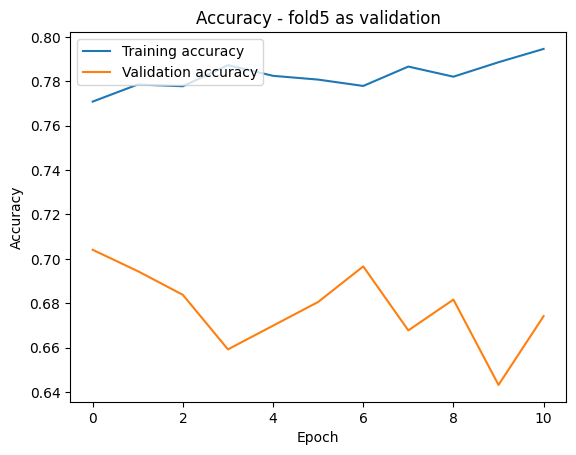

 50%|█████     | 5/10 [13:08<11:28, 137.62s/it]

Training using fold6 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.83661, saving model to model.h5
61/61 - 23s - loss: 0.5924 - accuracy: 0.7918 - val_loss: 0.8366 - val_accuracy: 0.6877 - lr: 0.0010 - 23s/epoch - 380ms/step
Epoch 2/30

Epoch 2: val_loss improved from 0.83661 to 0.83473, saving model to model.h5
61/61 - 8s - loss: 0.6118 - accuracy: 0.7777 - val_loss: 0.8347 - val_accuracy: 0.6962 - lr: 0.0010 - 8s/epoch - 137ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.83473
61/61 - 9s - loss: 0.5978 - accuracy: 0.7815 - val_loss: 0.9060 - val_accuracy: 0.6792 - lr: 0.0010 - 9s/epoch - 153ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.83473
61/61 - 8s - loss: 0.5812 - accuracy: 0.7912 - val_loss: 0.8693 - val_accuracy: 0.6950 - lr: 0.0010 - 8s/epoch - 139ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.83473
61/61 - 7s - loss: 0.5720 - accuracy: 0.7882 - val_loss: 1.0183 - val_accuracy: 0.6537 - lr: 0.0010 - 7s/epoch - 122

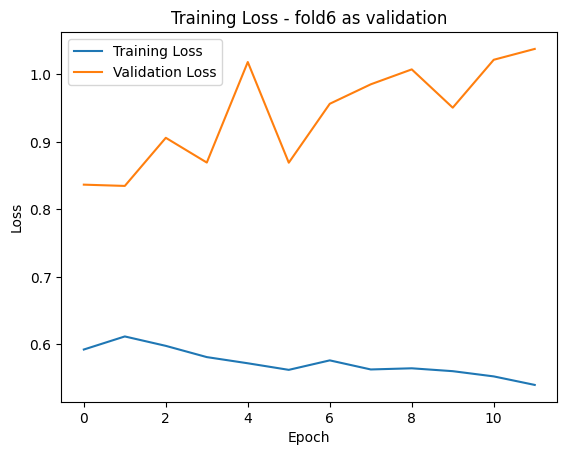

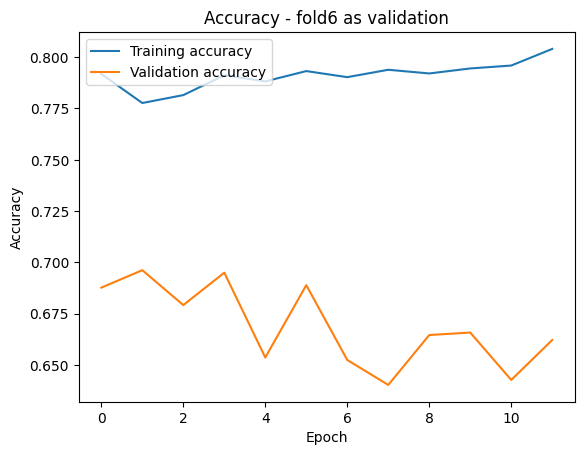

 60%|██████    | 6/10 [15:28<09:13, 138.43s/it]

Training using fold7 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.75870, saving model to model.h5
61/61 - 30s - loss: 0.5712 - accuracy: 0.7946 - val_loss: 0.7587 - val_accuracy: 0.7208 - lr: 0.0010 - 30s/epoch - 488ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.75870
61/61 - 10s - loss: 0.5584 - accuracy: 0.7955 - val_loss: 0.9078 - val_accuracy: 0.6611 - lr: 0.0010 - 10s/epoch - 168ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.75870
61/61 - 7s - loss: 0.5499 - accuracy: 0.8022 - val_loss: 0.8370 - val_accuracy: 0.6945 - lr: 0.0010 - 7s/epoch - 119ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.75870
61/61 - 9s - loss: 0.5556 - accuracy: 0.7938 - val_loss: 0.8911 - val_accuracy: 0.6611 - lr: 0.0010 - 9s/epoch - 154ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.75870
61/61 - 9s - loss: 0.5408 - accuracy: 0.8075 - val_loss: 0.8667 - val_accuracy: 0.6909 - lr: 0.0010 - 9s/epoch - 149ms/step
Epoch 6/30

Epoch 6:

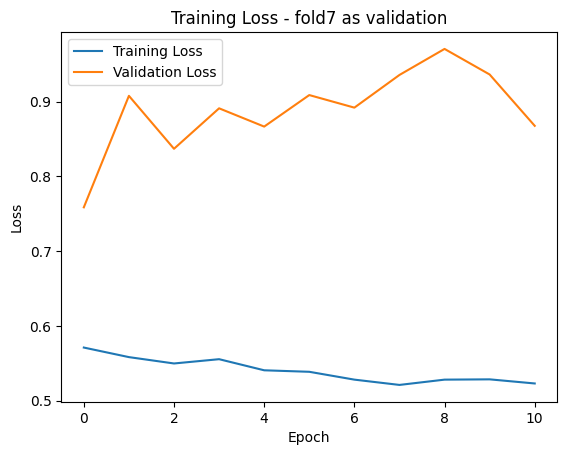

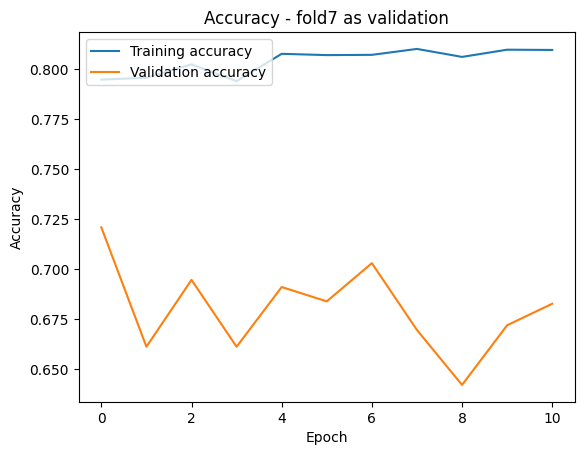

 70%|███████   | 7/10 [17:57<07:05, 141.80s/it]

Training using fold8 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.73640, saving model to model.h5
61/61 - 21s - loss: 0.5543 - accuracy: 0.7966 - val_loss: 0.7364 - val_accuracy: 0.7233 - lr: 0.0010 - 21s/epoch - 344ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.73640
61/61 - 10s - loss: 0.5420 - accuracy: 0.8041 - val_loss: 0.7985 - val_accuracy: 0.7258 - lr: 0.0010 - 10s/epoch - 169ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.73640
61/61 - 11s - loss: 0.5238 - accuracy: 0.8134 - val_loss: 0.8226 - val_accuracy: 0.7035 - lr: 0.0010 - 11s/epoch - 181ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.73640
61/61 - 8s - loss: 0.5263 - accuracy: 0.8111 - val_loss: 0.8634 - val_accuracy: 0.6911 - lr: 0.0010 - 8s/epoch - 123ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.73640
61/61 - 10s - loss: 0.5106 - accuracy: 0.8117 - val_loss: 0.7436 - val_accuracy: 0.7345 - lr: 0.0010 - 10s/epoch - 164ms/step
Epoch 6/30

Epoc

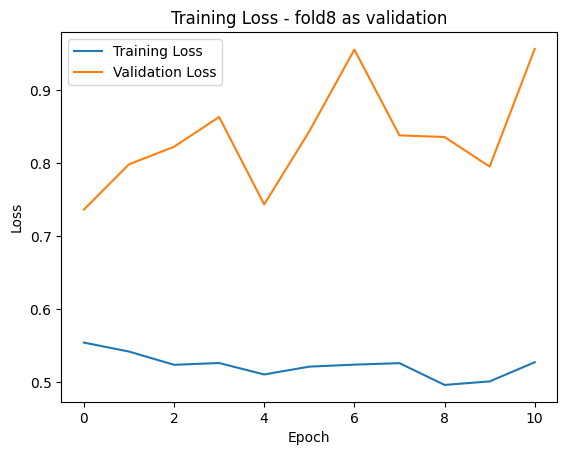

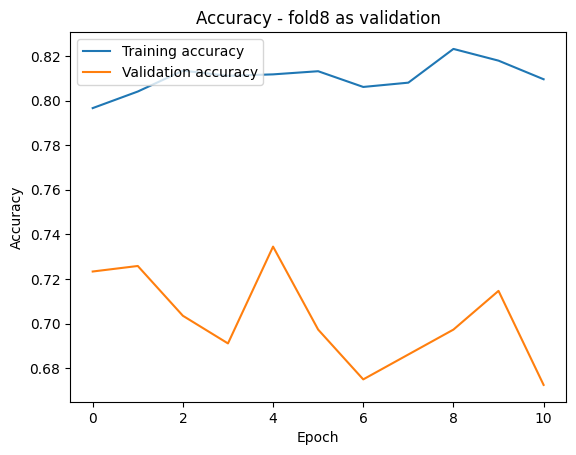

 80%|████████  | 8/10 [20:25<04:47, 143.66s/it]

Training using fold9 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.61365, saving model to model.h5
61/61 - 22s - loss: 0.5416 - accuracy: 0.8032 - val_loss: 0.6136 - val_accuracy: 0.7635 - lr: 0.0010 - 22s/epoch - 356ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.61365
61/61 - 9s - loss: 0.5160 - accuracy: 0.8156 - val_loss: 0.6966 - val_accuracy: 0.7414 - lr: 0.0010 - 9s/epoch - 140ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.61365
61/61 - 8s - loss: 0.5101 - accuracy: 0.8166 - val_loss: 0.6459 - val_accuracy: 0.7708 - lr: 0.0010 - 8s/epoch - 126ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.61365
61/61 - 10s - loss: 0.5136 - accuracy: 0.8145 - val_loss: 0.6568 - val_accuracy: 0.7549 - lr: 0.0010 - 10s/epoch - 162ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.61365
61/61 - 7s - loss: 0.5041 - accuracy: 0.8173 - val_loss: 0.7619 - val_accuracy: 0.7365 - lr: 0.0010 - 7s/epoch - 118ms/step
Epoch 6/30

Epoch 6:

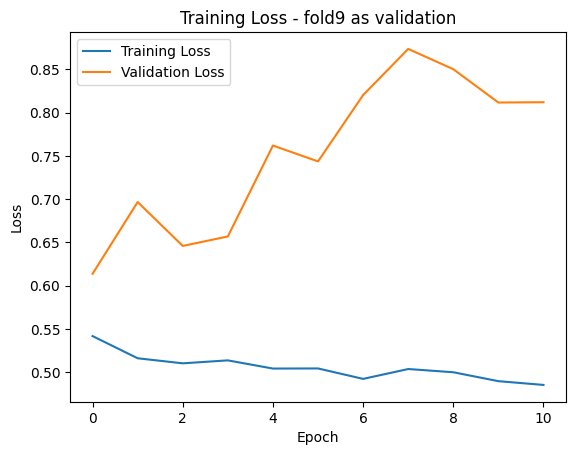

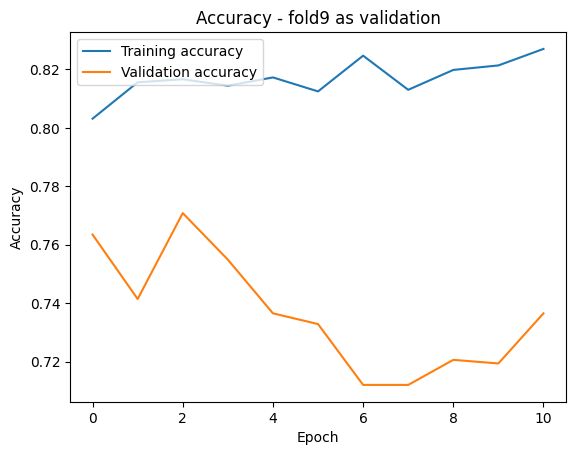

 90%|█████████ | 9/10 [22:31<02:18, 138.19s/it]

Training using fold10 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.60118, saving model to model.h5
61/61 - 22s - loss: 0.4990 - accuracy: 0.8249 - val_loss: 0.6012 - val_accuracy: 0.7778 - lr: 0.0010 - 22s/epoch - 368ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.60118
61/61 - 7s - loss: 0.4930 - accuracy: 0.8205 - val_loss: 0.6696 - val_accuracy: 0.7587 - lr: 0.0010 - 7s/epoch - 121ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.60118
61/61 - 10s - loss: 0.4857 - accuracy: 0.8227 - val_loss: 0.7528 - val_accuracy: 0.7264 - lr: 0.0010 - 10s/epoch - 162ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.60118
61/61 - 7s - loss: 0.4872 - accuracy: 0.8198 - val_loss: 0.7095 - val_accuracy: 0.7527 - lr: 0.0010 - 7s/epoch - 121ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.60118
61/61 - 8s - loss: 0.4743 - accuracy: 0.8254 - val_loss: 0.7043 - val_accuracy: 0.7515 - lr: 0.0010 - 8s/epoch - 124ms/step
Epoch 6/30

Epoch 6

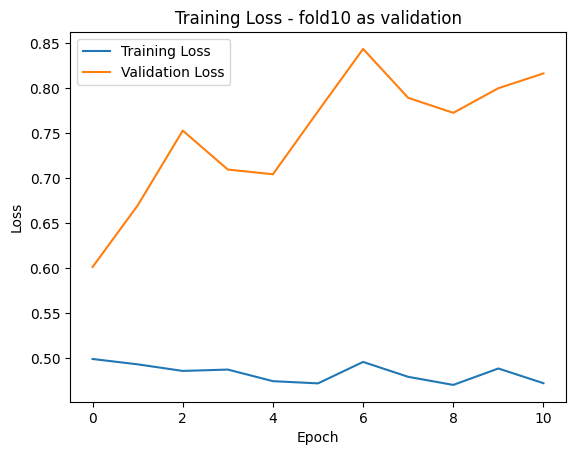

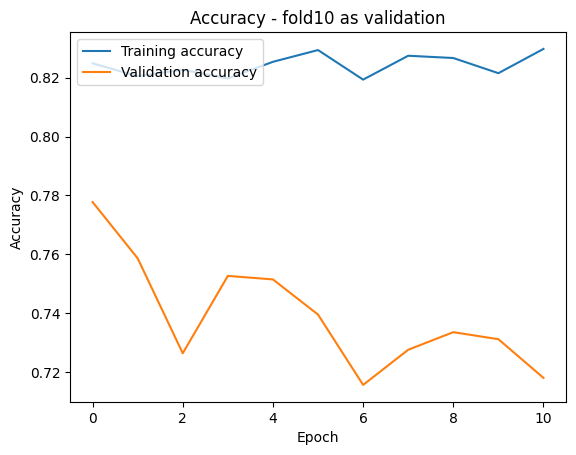

100%|██████████| 10/10 [24:42<00:00, 148.20s/it]


List of scores[0.550973653793335, 0.6261261105537415, 0.6043243408203125, 0.6000000238418579, 0.6741452813148499, 0.6622114181518555, 0.6825775504112244, 0.6724565625190735, 0.7365196347236633, 0.7180406451225281]
Average accuracy: 0.6527375221252442
Trained only the last -10 layers
27/27 [==============================] - 4s 26ms/step
Total-test-data; 837 	accurately-predicted-data: 601 	 wrongly-predicted-data:  236
Accuracy: 71.804 %


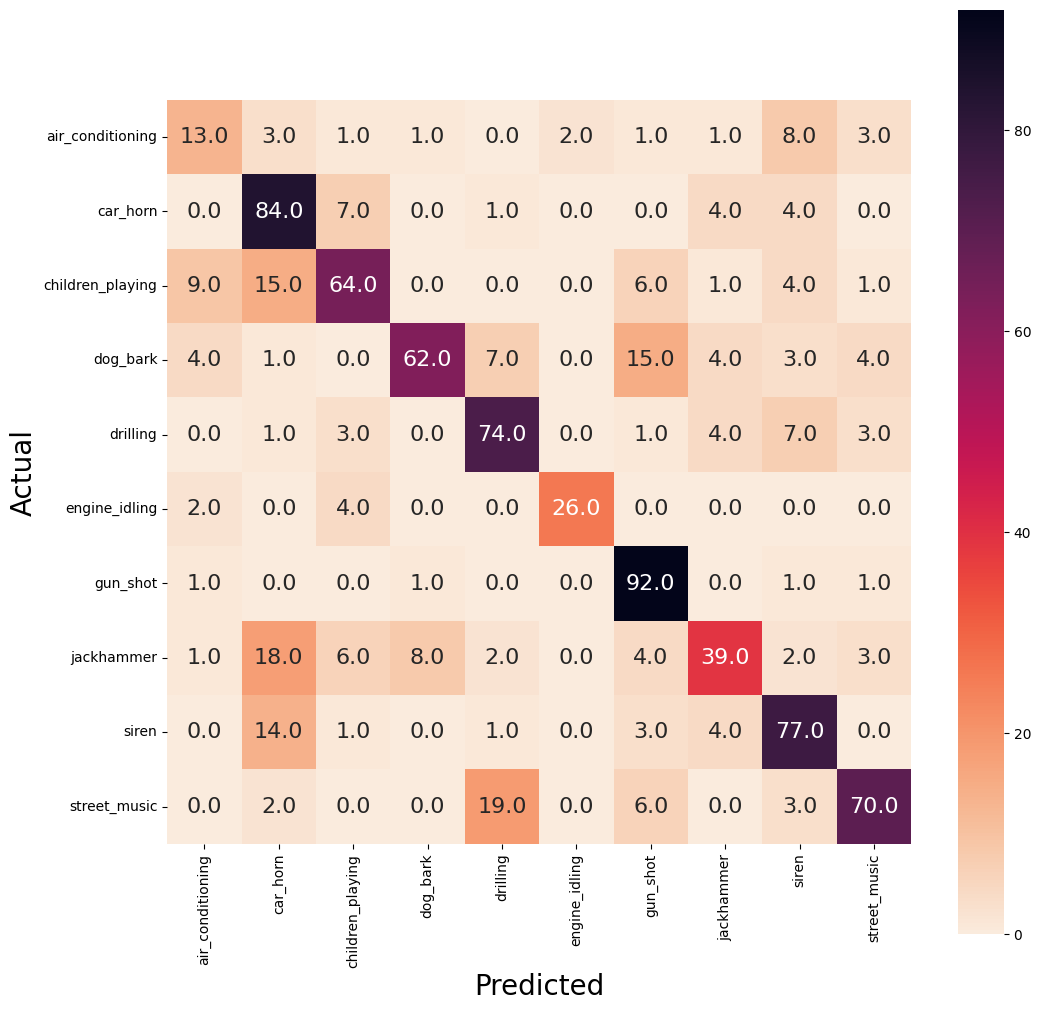

In [6]:
tensorflow.keras.backend.clear_session()

metric = 'accuracy' #evaluation metric
#metric = tensorflow.keras.metrics.MeanAveragePrecisionMetric(topn=2)
loss= 'categorical_crossentropy' #loss function

#training parameters
num_epoch = 30
batch_size = 128
early_stop = 10 # early stoppping after 3 epochs with no improvement of test data
#trainable layers needs a minus infront
trainable_layers = -10
dropout_rate = 0.5
learning_rate = 0.001


def model_k_cross(data):
    list_scores = []
    #Densenet121 model using pretrained weights from imagenet
    model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=input_shape[1:4], classes=10)

    x=model_d.output
    x= GlobalAveragePooling2D()(x)
    x= BatchNormalization()(x)
    x= Dropout(dropout_rate)(x)
    x= Dense(1024,activation='relu')(x)
    x= Dense(512,activation='relu')(x)
    x= BatchNormalization()(x)
    x= Dropout(dropout_rate)(x)
    preds=Dense(10,activation='softmax')(x) #FC-layer
    model=Model(inputs=model_d.input,outputs=preds)

    #instance of Adam optimizer
    Adam = keras.optimizers.Adam(learning_rate=learning_rate)


    #To avoid the problem of overfitting, avoid training the entire network. layer.trainable=False will freeze all the layers, keeping only the last eight layers (FC) to detect edges and blobs in the image. Once the model is fitted well, it can be fine-tuned by using layer.trainable=True.
    for layer in model.layers[:trainable_layers]:
        layer.trainable=False
    for layer in model.layers[trainable_layers:]:
        layer.trainable=True

    model.summary()



    for fold_name, fold_data in tqdm.tqdm(data.items()):
        tensorflow.keras.backend.clear_session()
        print(f"Training using {fold_name} as validation")
        X_val, y_val = fold_data[0], fold_data[1]
        X_train = []
        y_train = []

        for other_fold_name, other_fold_data in data.items():
            if other_fold_name == fold_name:
                continue

            X = other_fold_data[0]
            y = other_fold_data[1]
            X_train.extend(X)
            y_train.extend(y)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
        EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)


        #If the model sees no change in validation loss the ReduceLROnPlateau function will reduce the learning rate, which often benefits the model. The ImageDataGenerator function performs real-time data augmentation over generated tensor image data batches in a loop.
        anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
        datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)
        datagen.fit(X_train)

        history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                       steps_per_epoch=X_train.shape[0] //128,
                       epochs=num_epoch,
                       verbose=2,
                       callbacks=[anne, checkpoint, EarlyStoppingCallback],
                       validation_data=(X_val, y_val))

        # Evaluation
        scores = model.evaluate(X_val, y_val)
        print("Validation accuracy:", scores[1])
        list_scores.append(scores[1])


        # Plot training history - loss
        print(history.history.keys())
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"Training Loss - {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f"Accuracy - {fold_name} as validation")
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
        plt.show()


    average_acc = sum(list_scores) / len(list_scores)
    print(f'List of scores{list_scores}')
    print(f'Average accuracy: {average_acc}')
    print(f'Trained only the last {trainable_layers} layers')

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    label = ['air_conditioning', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

    Ypred = model.predict(X_val)

    for i in range(len(Ypred)):
        if np.argmax(Ypred[i]) == np.argmax(y_val[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)

        total += 1

    Ypred = np.argmax(Ypred, axis=1)
    Ytrue = np.argmax(y_val, axis=1)
    cm = confusion_matrix(Ytrue, Ypred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)


    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')


model_k_cross(data)

